In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

In [3]:
nz_coefs_df = []

# get pancancer coefs info for now
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,CDKN2A,PAAD,0.0001,42,0,7401
1,CDKN2A,PAAD,0.0001,42,1,7401
2,CDKN2A,PAAD,0.0001,42,2,7401
3,CDKN2A,PAAD,0.0001,42,3,7401
4,CDKN2A,STAD,0.0005,42,0,6346


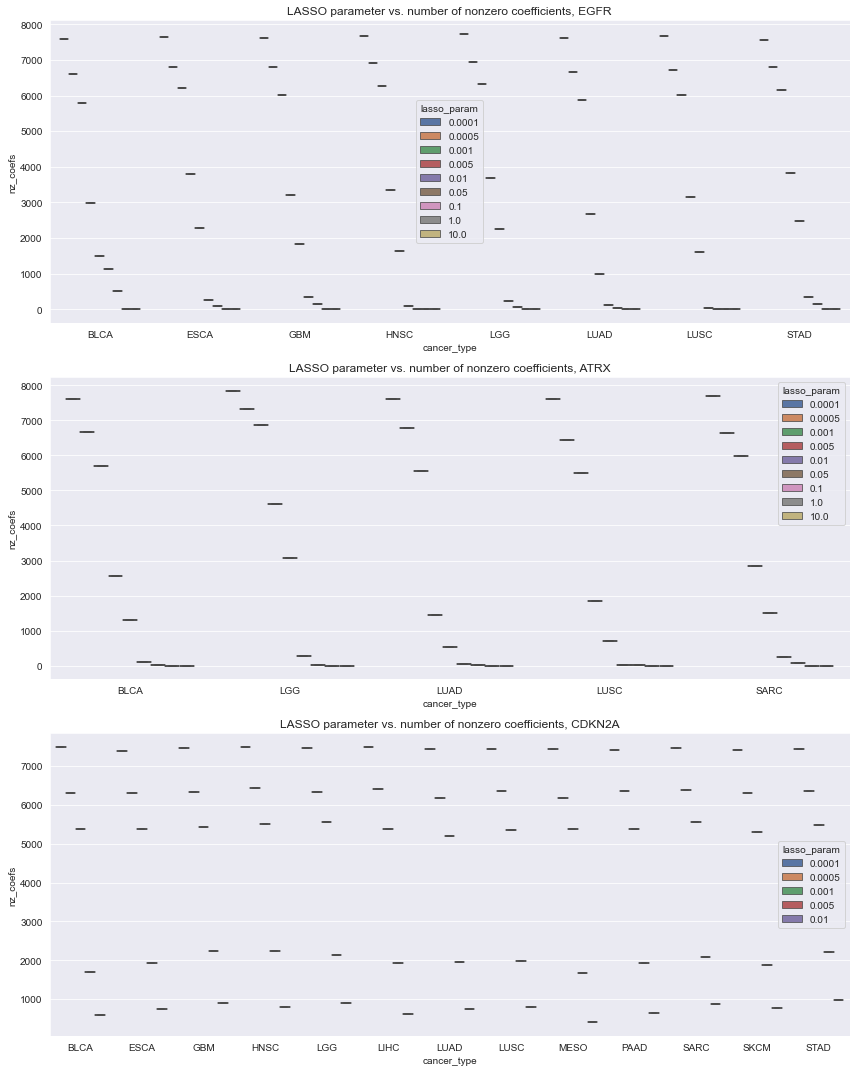

In [4]:
genes = ['EGFR', 'ATRX', 'CDKN2A']

sns.set({'figure.figsize': (12, 5*len(genes))})
fig, axarr = plt.subplots(len(genes), 1)

for ix, gene in enumerate(genes):
    ax = axarr[ix]
    sns.boxplot(
        data=(
            nz_coefs_df[nz_coefs_df.gene == gene]
              .sort_values(by=['cancer_type', 'lasso_param'])
        ), x='cancer_type', y='nz_coefs', hue='lasso_param', ax=ax
    )
    ax.set_title(f'LASSO parameter vs. number of nonzero coefficients, {gene}')
plt.tight_layout()

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir, training_dataset)
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.00000,CDKN2A,STAD,shuffled,42,train,0,all_other_cancers,0.0001
1,0.52959,0.17583,CDKN2A,STAD,shuffled,42,test,0,all_other_cancers,0.0001
2,1.00000,1.00000,CDKN2A,STAD,shuffled,42,cv,0,all_other_cancers,0.0001
3,1.00000,1.00000,CDKN2A,STAD,shuffled,42,train,1,all_other_cancers,0.0001
4,0.52137,0.24506,CDKN2A,STAD,shuffled,42,test,1,all_other_cancers,0.0001


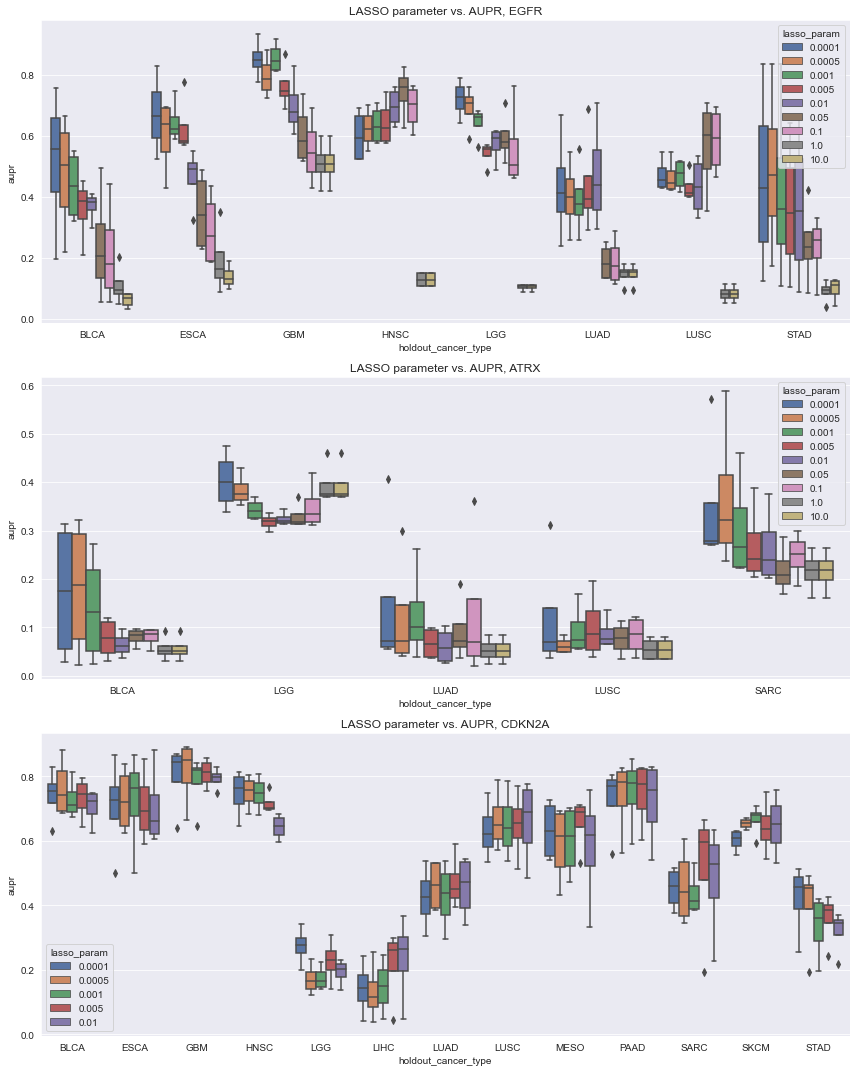

In [6]:
genes = ['EGFR', 'ATRX', 'CDKN2A']
metric = 'aupr'

sns.set({'figure.figsize': (12, 5*len(genes))})
fig, axarr = plt.subplots(len(genes), 1)

for ix, gene in enumerate(genes):
    ax = axarr[ix]
    sns.boxplot(
        data=(
            perf_df[(perf_df.gene == gene) &
                    (perf_df.signal == 'signal') &
                    (perf_df.data_type == 'test')]
              .sort_values(by=['holdout_cancer_type', 'lasso_param'])
        ), x='holdout_cancer_type', y=metric, hue='lasso_param', ax=ax
    )
    ax.set_title(f'LASSO parameter vs. {metric.upper()}, {gene}')
plt.tight_layout()